RDKit practice
======================
ref: [Link](https://www.rdkit.org/docs/GettingStartedInPython.html#working-with-molecules)


In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
#import numpy

## Managing molecule

### Generate and Save as Image


- generate molecule from SMILES
- visualize molecule to png file

In [37]:
m = Chem.MolFromSmiles('c1nccc2n1ccc2')
img = Draw.MolToImage(m)
img.save('test.png')

- Multiple image is also possible as follows

```python
>>> img = Draw.MolsToGridImage(ms[:8], molsPerRow=4, subImgSize=(200,200), legends=[x.GetProp("_Name") for x in ms[:8]])
```

- Look better with core alignment
```python
>>> p = Chem.MolFromSmiles('[nH]1cnc2cncnc21')
>>> subms = [x for x in ms if x.HasSubstructMatch(p)]

>>> AllChem.Compute2DCoords(p)
>>> for m in subms:
...     _ = AllChem.GenerateDepictionMatching2DStructure(m,p)

>>> img = Draw.MolsToGridImage(ms[:8], molsPerRow=4, subImgSize=(200,200), legends=[x.GetProp("_Name") for x in ms[:8]])
```

### Substructure

#### Manage with substructure

- substructure searching
```python
>>> m = Chem.MolFromSmiles('C1=CC=CC=C1OC')
>>> m.HasSubstructMatch(Chem.MolFromSmarts('CO'))
True
>>> m.HasSubstructMatch(Chem.MolFromSmiles('CO'))
True
```
  - `useChirality=True`를 이용해 stereochemistry도 찾을 수 있음. e.g.) `[C@H](F)`

In [38]:
from rdkit import Chem

class SidechainChecker(object):
    matchers = {
        'alkyl': lambda at: not at.GetIsAromatic(),
        'all_carbon': lambda at: at.GetAtomicNum() == 6
    }

    def __init__(self, query, pName="queryType"):
    # identify the atoms that have the properties we care about
        self._atsToExamine = [(x.GetIdx(), x.GetProp(pName)) for x in query.GetAtoms()
                              if x.HasProp(pName)]
        self._pName = pName

    def __call__(self, mol, vect):
        seen = [0] * mol.GetNumAtoms()
        for idx in vect:
            seen[idx] = 1
        # loop over the atoms we care about:
        for idx, qtyp in self._atsToExamine:
            midx = vect[idx]
            stack = [midx]
            atom = mol.GetAtomWithIdx(midx)
            # now do a breadth-first search from that atom, checking
            # all of its neighbors that aren't in the substructure
            # query:
            stack = [atom]
            while stack:
                atom = stack.pop(0)
                if not self.matchers[qtyp](atom):
                    return False
                seen[atom.GetIdx()] = 1
                for nbr in atom.GetNeighbors():
                    if not seen[nbr.GetIdx()]:
                        stack.append(nbr)
        return True

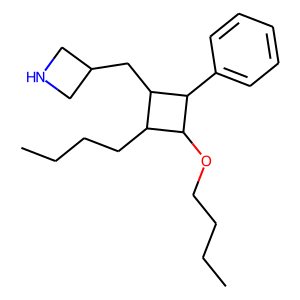

In [2]:
m = Chem.MolFromSmiles('C2NCC2CC1C(CCCC)C(OCCCC)C1c2ccccc2')
img = Draw.MolToImage(m)
img

In [75]:

p = Chem.MolFromSmarts('C1CCC1*')
print(m.GetSubstructMatches(p))

p.GetAtomWithIdx(4).SetProp('queryType','all_carbon')
chk = SidechainChecker(p)

params = Chem.SubstructMatchParameters()
params.setExtraFinalCheck(chk)
print(m.GetSubstructMatches(p, params))


p.GetAtomWithIdx(4).SetProp('queryType','alkyl')
chk = SidechainChecker(p)

params = Chem.SubstructMatchParameters()
params.setExtraFinalCheck(chk)
print(m.GetSubstructMatches(p, params))

((5, 6, 11, 17, 18), (5, 17, 11, 6, 7), (6, 5, 17, 11, 12), (6, 11, 17, 5, 4))
((5, 6, 11, 17, 18), (5, 17, 11, 6, 7))
((5, 17, 11, 6, 7), (6, 5, 17, 11, 12), (6, 11, 17, 5, 4))


- 가운데 사각형이 메인이며, 연결된 작용기 (sidechain)가 모두 C로만 이루어진것: 두개, alkyl계열: 3개

##### Transformation of molecules based on substructure

- Delete

In [76]:
m = Chem.MolFromSmiles('CC(=O)O')
patt = Chem.MolFromSmarts('C(=O)[OH]')
rm = AllChem.DeleteSubstructs(m,patt)
Chem.MolToSmiles(rm)

'C'

- Replacing

In [77]:
repl = Chem.MolFromSmiles('OC')
patt = Chem.MolFromSmarts('[$(NC(=O))]')
m = Chem.MolFromSmiles('CC(=O)N')
rms = AllChem.ReplaceSubstructs(m,patt,repl)
Chem.MolToSmiles(rms[0])

'COC(C)=O'

- Moving sidechain

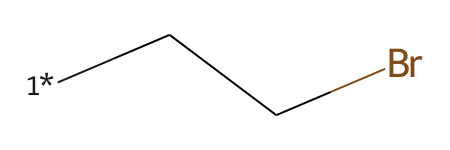

In [ ]:
m1 = Chem.MolFromSmiles('BrCCc1cncnc1C(=O)O')
core = Chem.MolFromSmiles('c1cncnc1')
tmp = Chem.ReplaceSidechains(m1,core) # core only
Chem.MolToSmiles(tmp)
tmp = Chem.ReplaceCore(m1,core) # sidechain only
# sidechain은 발견 순서대로 나오지만, labelByIndex=True 추가하면 core index 순서대로 나옴
rs = Chem.GetMolFrags(tmp,asMols=True)
# 두 개의 sidechain을 각각의 molecule로 분리함
rs[0]

##### find maximum common substructure (MCS)

In [92]:
from rdkit.Chem import rdFMCS
mol1 = Chem.MolFromSmiles("O=C(NCc1cc(OC)c(O)cc1)CCCC/C=C/C(C)C")
mol2 = Chem.MolFromSmiles("CC(C)CCCCCC(=O)NCC1=CC(=C(C=C1)O)OC")
mol3 = Chem.MolFromSmiles("c1(C=O)cc(OC)c(O)cc1")
mols = [mol1,mol2,mol3]
res = rdFMCS.FindMCS(mols)
res, res.numAtoms, res.numBonds, res.smartsString, res.canceled

(<rdkit.Chem.rdFMCS.MCSResult at 0x237d58e2020>,
 10,
 10,
 '[#6]1(-[#6]):[#6]:[#6](-[#8]-[#6]):[#6](:[#6]:[#6]:1)-[#8]',
 False)

## Fingerprints

### RDKit default fingerprint, binary

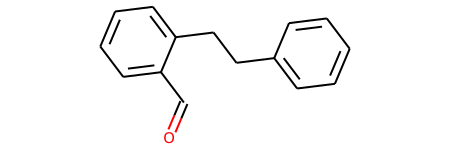

In [108]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw

m = Chem.MolFromSmiles("O=C(NCc1cc(OC)c(O)cc1)CCCC/C=C/C(C)C")
m = Chem.MolFromSmiles('OC(CN1C=NC=N1)(CN1C=NC=N1)C1=C(F)C=C(F)C=C1')
m = Chem.MolFromSmiles('O=Cc1ccccc1CCc1ccccc1')
info = {}
fp_rdk = Chem.RDKFingerprint(m, bitInfo=info)
fp_rdk.GetNumBits()
m

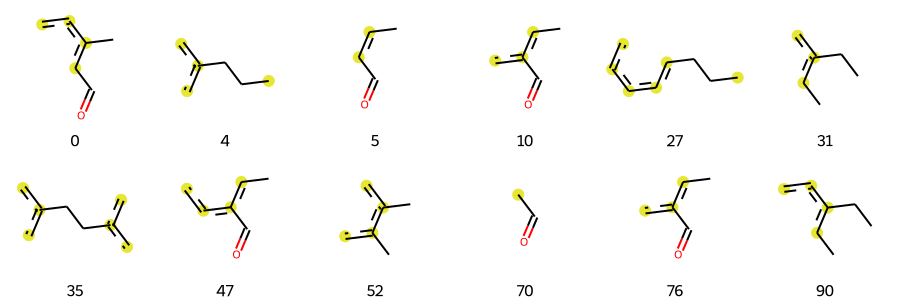

In [107]:
tpls = [(m, k, info) for k in info]
Draw.DrawRDKitBits(tpls[:12], molsPerRow=6, legends=[str(k) for k in info][:12])

### Pair-wise fingerprint

In [206]:
from rdkit.Chem.AtomPairs import Pairs

fp_pair = Pairs.GetAtomPairFingerprint(m)
fp_pair_hash = Pairs.GetHashedAtomPairFingerprint(m)
fp_pair.GetLength()/1024**2, fp_pair_hash.GetLength()

(8.0, 2048)

- `541730`번 bit는 `(C,1,0)`과 `(C,1,0)`의 double bond (`2`) 를 의미함
- `(C,1,0)`에서 `C`는 원소 (carbon), `1`은 1개의 이웃, `0`은 0개의 pi electron을 의미함
- `(C,2,0), 3, (C,1,0)` 일 경우 2개의 이웃을 갖는 탄소 원자가 1개의 이웃을 갖는 탄소 원자와 triple bond를 하고 있으며, 모든 본딩에 pi electron은 기여하지 않는 bond를 의미함.

In [115]:
fp_pair[541730], Pairs.ExplainPairScore(541730)

(1, (('C', 1, 0), 2, ('C', 1, 0)))

### Torsion fingerprint

In [138]:
from rdkit.Chem.AtomPairs import Torsions

fp_tor = Torsions.GetTopologicalTorsionFingerprintAsIntVect(m)
#fp_tor = np.array(fp_tor.ToList())
fp_tor.GetLength()#/1024**3

68719476735

사이즈가 너무 커서 list 변환이 불가능하며... 유용하진 않을 것으로 보임

### Morgan Fingerprints (Circular fingerprints)

- count based fingerprint

In [197]:
from rdkit import Chem
from rdkit.Chem import AllChem

info = {}
info_hash = {}
m = Chem.MolFromSmiles("O=C(NCc1cc(OC)c(O)cc1)CCCC/C=C/C(C)C")
fp_mor = AllChem.GetMorganFingerprint(m, 2, bitInfo=info)
fp_mor_hash = AllChem.GetHashedMorganFingerprint(m, 2, bitInfo=info_hash)

fp_mor.GetLength(), fp_mor_hash.GetLength()

(4294967295, 2048)

In [20]:
len(info), info[951226070], info[230478851]

(47, ((11, 1), (12, 1)), ((5, 2),))

In [202]:
info_hash, info

({1: ((19, 0),),
  41: ((1, 1),),
  80: ((3, 0), (13, 0), (14, 0), (15, 0), (16, 0)),
  197: ((2, 1),),
  249: ((7, 2),),
  255: ((3, 1),),
  283: ((20, 1), (21, 1)),
  310: ((12, 2),),
  333: ((2, 2),),
  401: ((16, 1),),
  614: ((6, 2),),
  650: ((0, 0),),
  694: ((17, 0), (18, 0)),
  695: ((7, 0),),
  725: ((18, 2),),
  775: ((16, 2),),
  807: ((1, 0), (10, 0)),
  841: ((8, 1),),
  875: ((5, 1),),
  1027: ((5, 2),),
  1057: ((8, 0), (20, 0), (21, 0)),
  1152: ((2, 0),),
  1168: ((9, 2),),
  1267: ((14, 2),),
  1314: ((19, 1),),
  1356: ((17, 1),),
  1380: ((4, 0), (6, 0), (9, 0)),
  1440: ((15, 2),),
  1475: ((11, 2),),
  1536: ((7, 1), (19, 2)),
  1564: ((13, 1),),
  1573: ((3, 2),),
  1589: ((1, 2),),
  1602: ((10, 1),),
  1607: ((9, 1),),
  1624: ((18, 1),),
  1718: ((13, 2),),
  1750: ((11, 1), (12, 1)),
  1754: ((4, 1),),
  1779: ((4, 2),),
  1873: ((5, 0), (11, 0), (12, 0)),
  1911: ((14, 1), (15, 1)),
  1917: ((0, 1),),
  1970: ((6, 1),),
  1991: ((17, 2),)},
 {26234434: ((10

- Description of fingerprint
  - Total 47 non-zero values in fingerprint
  - bit 951226070 is set twice by atom 11 and atom 12 at radius 1.
  - bit 230478851 is set once by atom 5 at radius 2

- as bit vector (e.g. nBits=1024) - not working
- Feature based invariants (similar to FCFP fingerprints) can be used (useFeatures=True)

In [193]:
#fp_mor_bit = AllChem.GetMorganFingerprint(m, 2, nBits=1024) # not working
info_feat = {}
fp_mor_feat = AllChem.GetMorganFingerprint(m, 2, useFeatures=True, bitInfo=info_feat)
fp_mor_feat = AllChem.GetHashedMorganFingerprint(m, 2, useFeatures=True, bitInfo=info_feat)
fp_mor_feat.GetLength()

2048

In [196]:
len(info_feat), info_feat

(35,
 {0: ((1, 0),
   (3, 0),
   (8, 0),
   (13, 0),
   (14, 0),
   (15, 0),
   (16, 0),
   (17, 0),
   (18, 0),
   (19, 0),
   (20, 0),
   (21, 0)),
  1: ((2, 0),),
  2: ((0, 0), (7, 0)),
  3: ((10, 0),),
  4: ((4, 0), (5, 0), (6, 0), (9, 0), (11, 0), (12, 0)),
  114: ((9, 2),),
  124: ((13, 2),),
  132: ((3, 2),),
  188: ((4, 2),),
  277: ((17, 2),),
  309: ((6, 2),),
  357: ((16, 2),),
  428: ((4, 1),),
  646: ((7, 2),),
  691: ((1, 1),),
  779: ((2, 1),),
  792: ((13, 1), (14, 1), (15, 1), (16, 1)),
  808: ((9, 1),),
  826: ((3, 1), (18, 2)),
  857: ((17, 1), (18, 1)),
  964: ((2, 2),),
  1011: ((11, 2),),
  1083: ((6, 1),),
  1085: ((20, 1), (21, 1)),
  1147: ((1, 2),),
  1219: ((8, 1),),
  1478: ((5, 2),),
  1488: ((14, 2), (15, 2)),
  1556: ((12, 2),),
  1668: ((19, 1),),
  1864: ((19, 2),),
  1925: ((10, 1),),
  1990: ((7, 1),),
  2017: ((5, 1), (11, 1), (12, 1)),
  2040: ((0, 1),)})

### MACCS Key

In [136]:
m = Chem.MolFromSmiles("O=C(NCc1cc(OC)c(O)cc1)CCCC/C=C/C(C)C")
fp_mac = Chem.MACCSkeys.GenMACCSKeys(m)

fp_mac.GetNumBits()

167

### Similarity measure

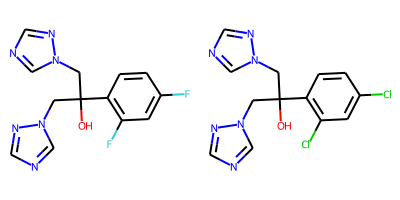

In [210]:
m1 = Chem.MolFromSmiles("O=C(NCc1cc(OC)c(O)cc1)CCCC/C=C/C(C)C")
m2 = Chem.MolFromSmiles('OC(CN1C=NC=N1)(CN1C=NC=N1)C1=C(F)C=C(F)C=C1')
m3 = Chem.MolFromSmiles('OC(CN1C=NC=N1)(N)C1=C(F)C=CC=C1')
m4 = Chem.MolFromSmiles('OC(CN1C=NC=N1)(CN1C=NC=N1)C1=C(Cl)C=C(Cl)C=C1')
fp_fns = {
    'RDK': lambda x: Chem.RDKFingerprint(x),
    'AtomPair': lambda x: Pairs.GetAtomPairFingerprint(x),
    'AtomPair_hash': lambda x: Pairs.GetHashedAtomPairFingerprint(x),
    'Torsion': lambda x: Torsions.GetTopologicalTorsionFingerprint(x),
    'Torsion_hash': lambda x: Torsions.GetHashedTopologicalTorsionFingerprint(x),
    'Morgan': lambda x: AllChem.GetMorganFingerprint(x, 2, useFeatures=True),
    'Morgan_hash': lambda x: AllChem.GetHashedMorganFingerprint(x, 2, useFeatures=True),    
    'MACCS': lambda x: Chem.MACCSkeys.GenMACCSKeys(x),
}
Draw.MolsToGridImage([m2, m4], molsPerRow=2)

In [241]:
from rdkit import DataStructs
for k, fnc in fp_fns.items():
    sim = DataStructs.DiceSimilarity(fnc(m3), fnc(m1))
    print('{:<9s}: {:.3f}'.format(k, sim))

RDK      : 0.293
AtomPair : 0.148
AtomPair_hash: 0.188
Torsion  : 0.069
Torsion_hash: 0.103
Morgan   : 0.264
Morgan_hash: 0.264
MACCS    : 0.489


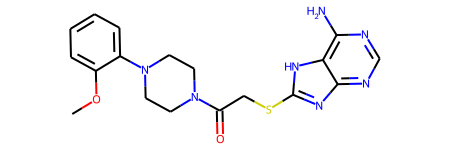

In [242]:
Chem.MolFromSmiles('COc1ccccc1N2CCN(CC2)C(=O)CSc3nc4ncnc(N)c4[nH]3')

## Property discriptors
41 + 13 descriptors from RDKit

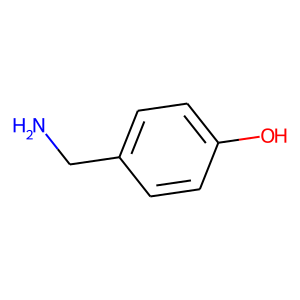

In [264]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem, rdMolDescriptors, Descriptors
from inspect import getmembers, isfunction

m = Chem.MolFromSmiles("O=C(NCc1cc(OC)c(O)cc1)CCCC/C=C/C(C)C")
m = Chem.MolFromSmiles("NCc1ccc(O)cc1")
Draw.MolToImage(m)

### Descriptors

In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from inspect import getmembers, isfunction

acr2_list = []
desc_list = []
for n,f in getmembers(Descriptors, isfunction):
    if n.startswith('AUTOCORR2D'):
        acr2_list.append((n,f))
    elif n.startswith('_'):
        break
    else:
        desc_list.append((n,f))

#desc_feature = np.array([d(m) for _, d in desc_list])
#acr2_feature = np.array([d(m) for _, d in acr2_list])

print(len(acr2_list), len(desc_list))

192 122


#### QM9 Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [ ]:
df = pd.read_csv('D:/DATA/polymers/QM9/qm9_origin.csv')
feat_qm9_desc = []
feat_qm9_acr2 = []
for i, data in tqdm(df.iterrows(), total=len(df.index)):
    m = Chem.MolFromSmiles(data.smiles)
    feat_qm9_desc.append([d(m) for _, d in desc_list])
    feat_qm9_acr2.append([d(m) for _, d in acr2_list])

In [98]:
m.GetNumBonds()

12

In [94]:
np.array([b.GetStereo() for b in bonds])
rstr = Chem.MolFromSmarts('[!$(*#*)&!D1]-&!@[!$(*#*)&!D1]')

m.GetSubstructMatches(rstr), Chem.Lipinski.NumRotatableBonds(m), Descriptors.NumRotatableBonds(m)

(((1, 3), (3, 5), (5, 6), (6, 7), (7, 10)), 4, 4)

In [163]:
feat_qm9_desc = np.array(feat_qm9_desc)
print(feat_qm9_desc.shape)
mask = np.std(feat_qm9_desc, axis=0) == 0
feat_qm9_desc = feat_qm9_desc[:, ~mask]
print(feat_qm9_desc.shape)

feat_qm9_acr2 = np.array(feat_qm9_acr2)
print(feat_qm9_acr2.shape)
mask = np.std(feat_qm9_acr2, axis=0) == 0
feat_qm9_acr2 = feat_qm9_acr2[:, ~mask]
print(feat_qm9_acr2.shape)

(133885, 115)
(133885, 115)
(133885, 192)
(133885, 192)


- load from saved features

In [4]:
df = pd.read_csv('D:/DATA/polymers/QM9/rdkit_feature.csv')
name_qm9_desc, name_qm9_acr2 = [n for n in df.columns if not n.startswith('ACR2D')], [n for n in df.columns if n.startswith('ACR2D')]
feat_qm9_desc, feat_qm9_acr2 = df.values[:,:len(name_qm9_desc)], df.values[:,len(name_qm9_desc):]
corr_qm9_desc = np.corrcoef(feat_qm9_desc.T)
corr_qm9_acr2 = np.corrcoef(feat_qm9_acr2.T)

mask_qm9_desc = np.ones(len(desc_list), dtype=bool)
mask_qm9_desc[[i for i, (n, _) in enumerate(desc_list) if n not in name_qm9_desc]] = False
mask_qm9_acr2 = np.ones(len(acr2_list), dtype=bool)
mask_qm9_acr2[[i for i, (n, _) in enumerate(acr2_list) if n.replace('AUTOCORR','ACR') not in name_qm9_acr2]] = False

- banned feature list

In [11]:
blacklist_0_var = [n for i, (n, _) in enumerate(desc_list) if n not in name_qm9_desc]
blacklist_0_var

['EState_VSA11',
 'NumRadicalElectrons',
 'SMR_VSA8',
 'SlogP_VSA12',
 'SlogP_VSA7',
 'SlogP_VSA9',
 'VSA_EState10']

- visualization

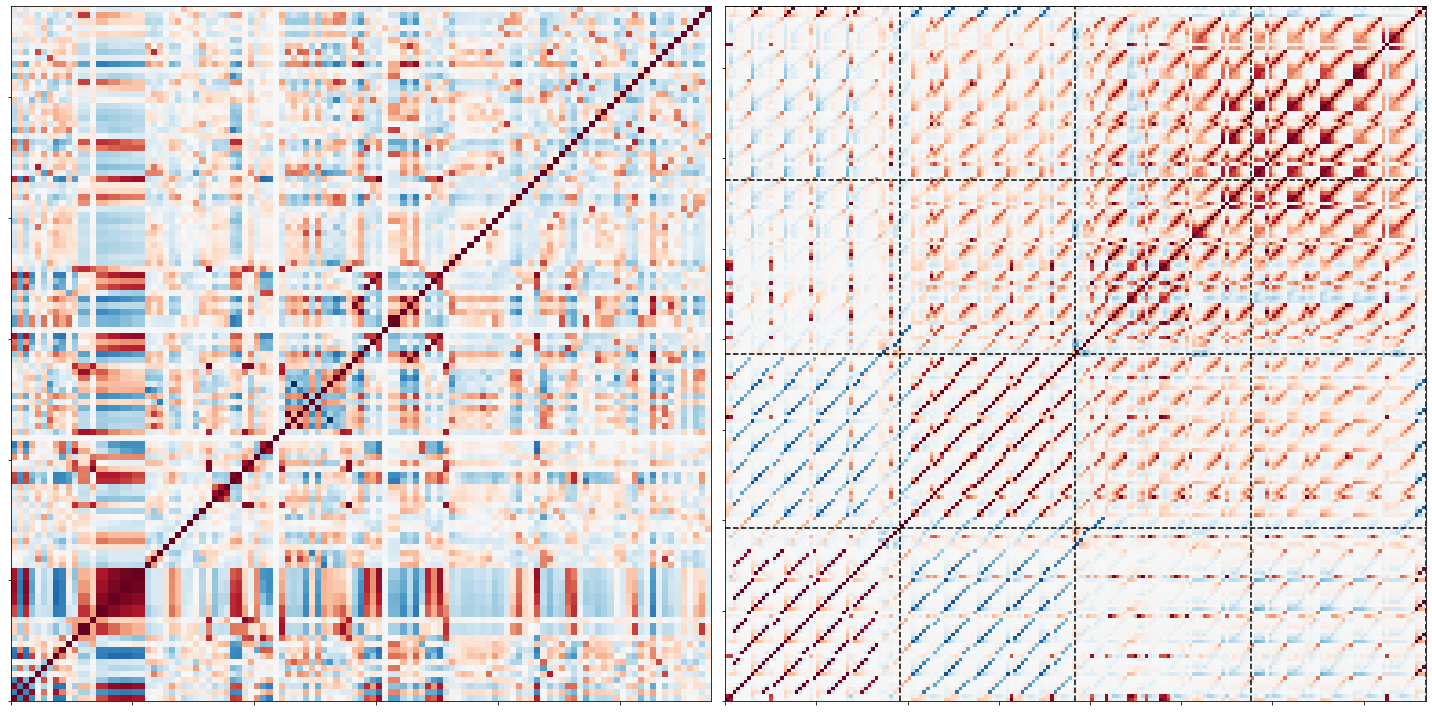

In [244]:
f, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].pcolormesh(corr_qm9_desc, cmap='RdBu_r', vmin=-1, vmax=1)
axs[1].pcolormesh(corr_qm9_acr2, cmap='RdBu_r', vmin=-1, vmax=1)
for i in range(1,5):
    axs[1].axvline(i*48, ls='--', color=[0,0,0])
    axs[1].axhline(i*48, ls='--', color=[0,0,0])
for ax in axs: 
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.tight_layout()

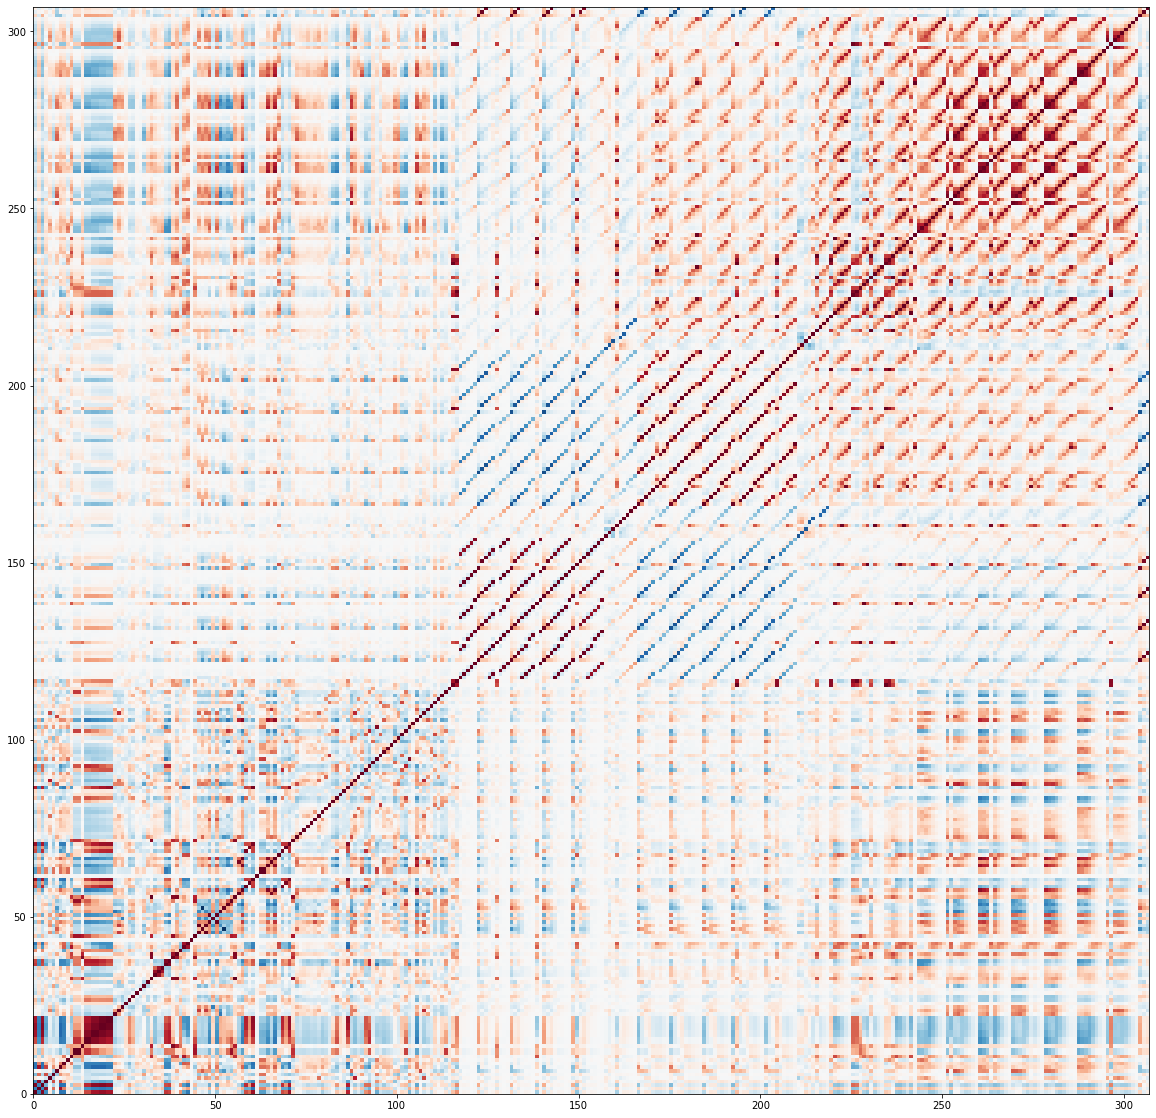

In [43]:
corrs_all = np.corrcoef(np.vstack([feat_qm9_desc.T, feat_qm9_acr2.T]))
plt.figure(figsize=(20,20))
plt.pcolormesh(corrs, cmap='RdBu_r', vmin=-1, vmax=1)

 #### F-polymer Dataset

In [45]:
from calendar import c


dffp = pd.read_csv('D:/DATA/polymers/f-polymer/Fea_Gene_20220603_DieEC_Total.csv')
f_mols = set(dffp[[f'Monomer_{a}' for a in 'ABCDE']].values.reshape(-1))
print(f_mols)

feat_fpoly_desc = []
feat_fpoly_acr2 = []
for smiles in f_mols:
    if smiles == 'Did not work': continue
    m = Chem.MolFromSmiles(smiles)
    feat_fpoly_desc.append([fnc(m) for n, fnc in desc_list])
    feat_fpoly_acr2.append([fnc(m) for n, fnc in acr2_list])

feat_fpoly_desc = np.array(feat_fpoly_desc)
feat_fpoly_desc = feat_fpoly_desc[:,mask_qm9_desc]
mask_fpoly_desc = np.std(feat_fpoly_desc, axis=0) == 0

feat_fpoly_acr2 = np.array(feat_fpoly_acr2)
feat_fpoly_acr2 = feat_fpoly_acr2[:,mask_qm9_acr2]
mask_fpoly_acr2 = np.std(feat_fpoly_acr2, axis=0) == 0

corr_fpoly_desc = np.corrcoef(feat_fpoly_desc.T)
corr_fpoly_acr2 = np.corrcoef(feat_fpoly_acr2.T)

corr_fpoly_all = np.corrcoef(np.vstack([feat_fpoly_desc.T, feat_fpoly_acr2.T]))

{'[O-]C(=O)C(=C)C(F)(F)F', 'CC(=C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)F', 'C=CC(=O)Oc1ccccc1', 'CC(=C)C(=O)OCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F', 'CC(=C)C(=O)OCC(F)(F)F', 'CC(=C)C(O)=O', 'CC(=C)C(=O)OC1CC2CCC1(C)C2(C)C', 'CC(=C)C(=O)OCC(F)(F)C(F)(F)F', 'Did not work', 'CCCCOC(=O)C(C)=C', 'CC(=O)CC(=O)OCCOC(=O)C(C)=C', 'CC(=C)C(=O)OCCO', 'FC(F)(F)COC(=O)C=C', 'CN(C)CCOC(=O)C(C)=C', 'COC(=O)C(C)=C', 'C=CC(=O)OCC1CCCO1', 'OCCOC(=O)C=C', 'FC(F)(F)C(F)(F)C(F)(F)COC(=O)C=C', 'CCCOC(=O)C=C', 'CCCCCCCCCCCCCCCCCCOC(=O)C(C)=C', 'C=CC(=O)OCCC#N', 'FC(F)(F)C(F)(F)C(F)(F)C(F)(F)CCOC(=O)C=C', 'CC(=C)C(=O)Nc1ccccc1', 'CC(=C)C(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)F', 'C=CC(=O)OCCOc1ccccc1', 'OC(=O)C=C', 'CC(=C)C(=O)OCc1occc1', 'CC1(C)[C@H]2CC[C@]1(C)C(C2)OC(=O)C=C', 'CC(=C)C(=O)OC1CCCCC1', 'CCOC(=O)C(C)=C', 'COC(=O)C=C', 'CC(=C)C(=O)OCc1ccccc1', 'CC(=C)C(=O)OC(C)(C)C', 'CCCCCCOC(=O)C(C)=C', 'CC(=C)C(=O)OCC(F)(F)[C@H](F)C(F)(F)F', 'CC(C)COC(=O)C(C)=C', 'FC(F)(F)C(OC(=O)C=C)C(F)(F)F', 'CC(=C)C(=O)OCC

c:\Users\Yang\anaconda3\envs\poly\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\Yang\anaconda3\envs\poly\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


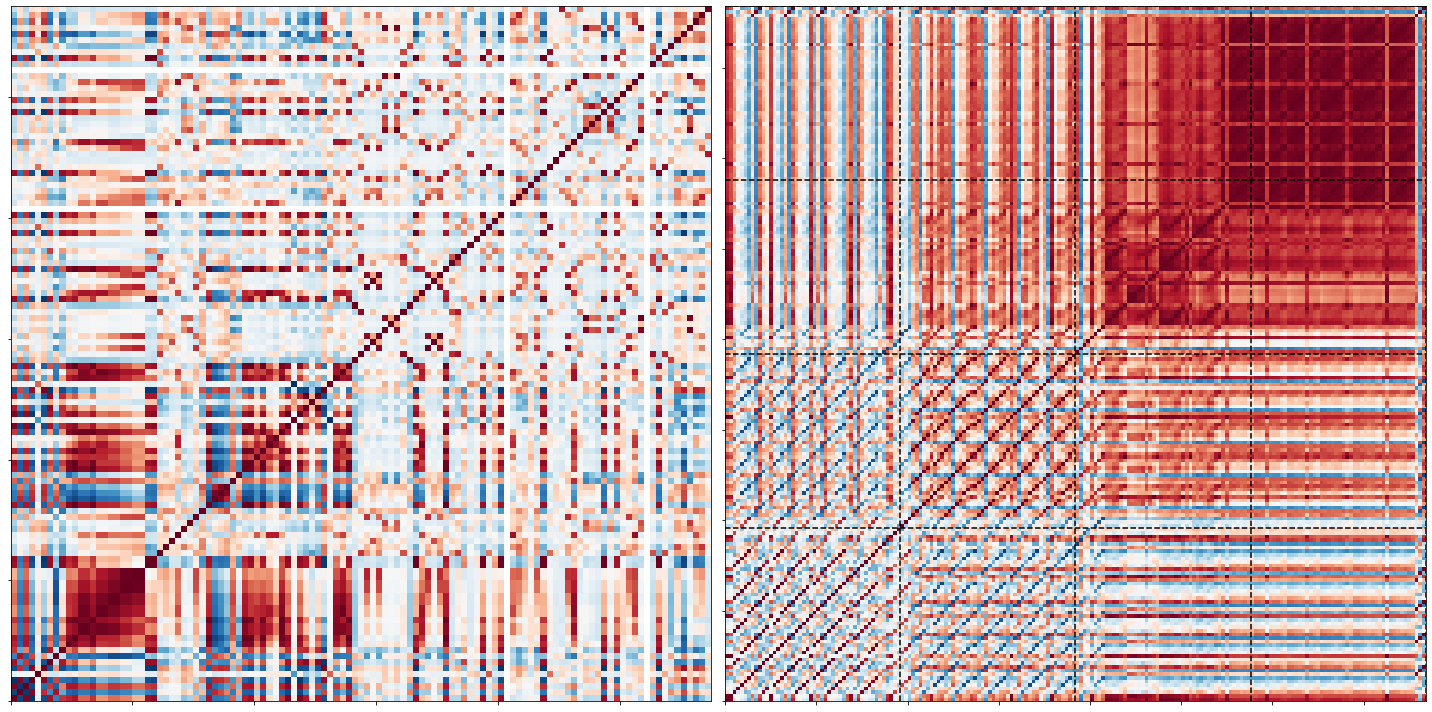

In [254]:
f, axs = plt.subplots(1, 2, figsize=(20,10))
axs[0].pcolormesh(corr_fpoly_desc, cmap='RdBu_r', vmin=-1, vmax=1)
axs[1].pcolormesh(corr_fpoly_acr2, cmap='RdBu_r', vmin=-1, vmax=1)
for i in range(1,5):
    axs[1].axvline(i*48, ls='--', color=[0,0,0])
    axs[1].axhline(i*48, ls='--', color=[0,0,0])
for ax in axs: 
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.tight_layout()

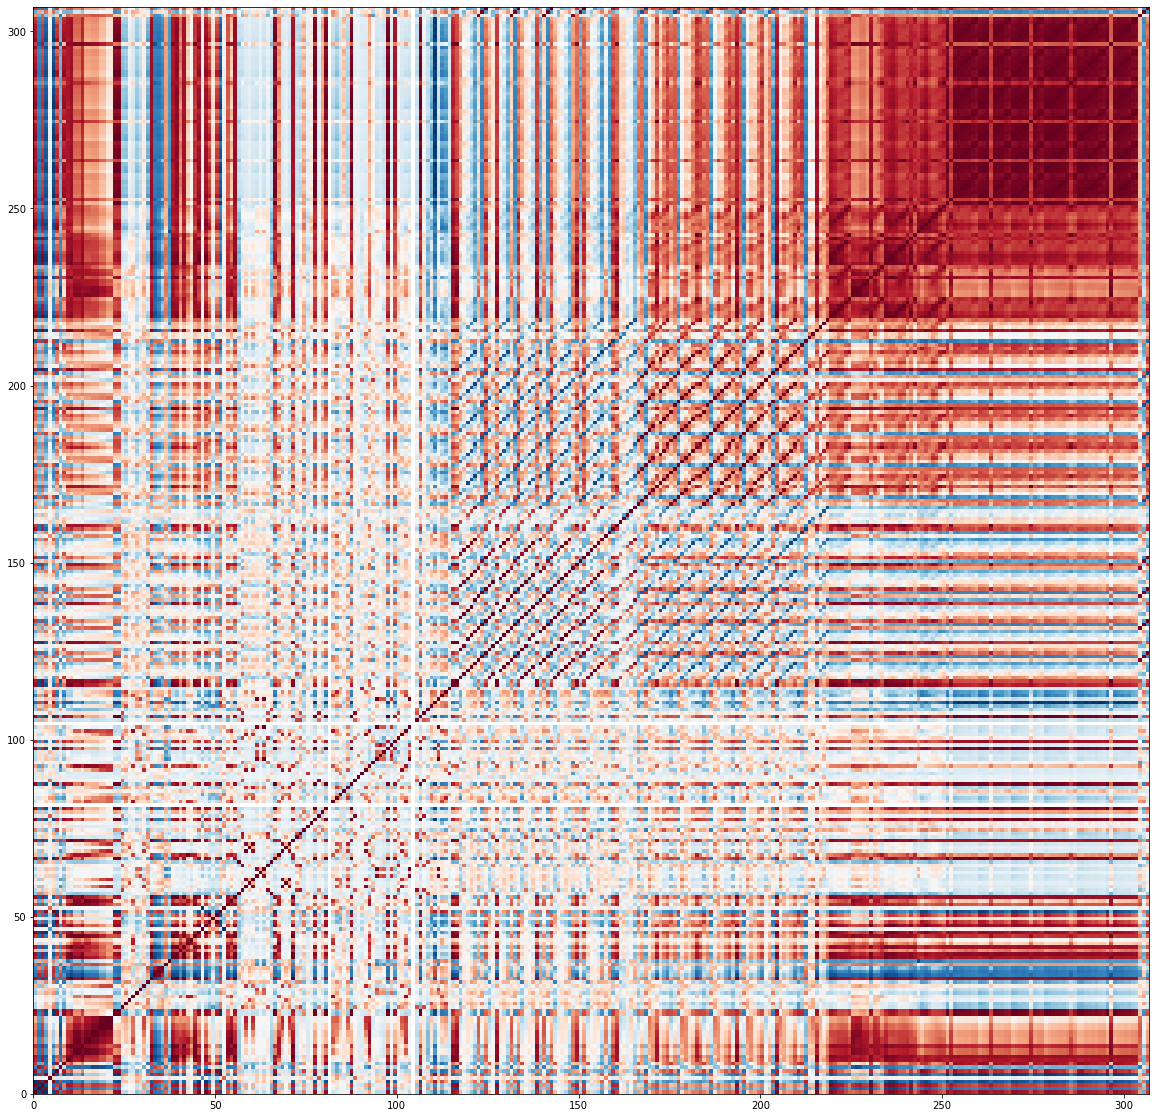

In [46]:
plt.figure(figsize=(20,20))
plt.pcolormesh(corr_fpoly_all, cmap='RdBu_r', vmin=-1, vmax=1)

#### Comparison

- Correlation coefficient 비교

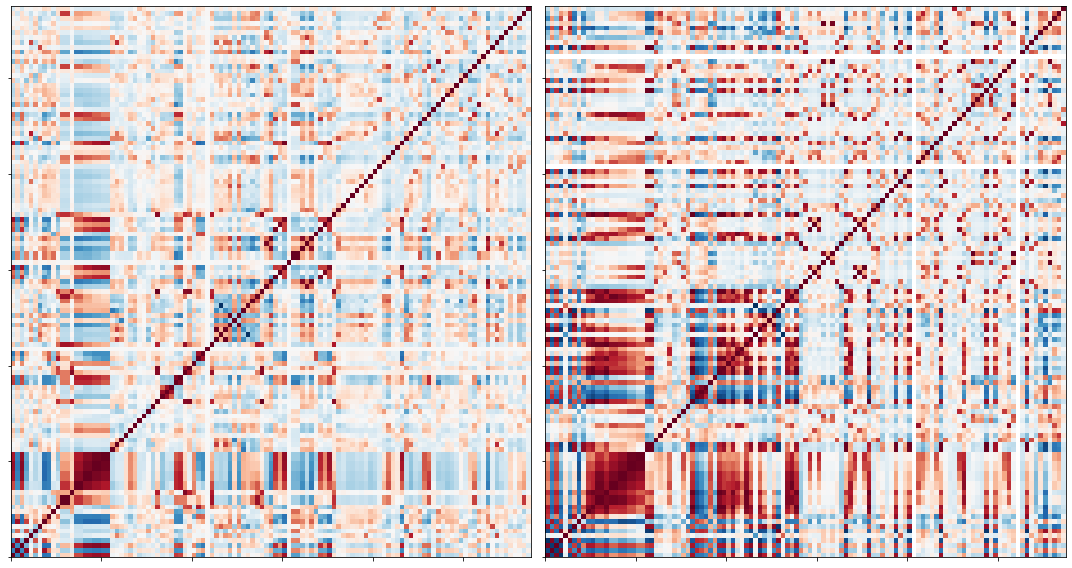

In [256]:
f, axs = plt.subplots(1, 2, figsize=(15,8))
axs[0].pcolormesh(corr_qm9_desc, cmap='RdBu_r', vmin=-1, vmax=1)
axs[1].pcolormesh(corr_fpoly_desc, cmap='RdBu_r', vmin=-1, vmax=1)
for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.tight_layout()

In [11]:
def screen_by_cc(corr, names, th, info=False):
    blacklist = []
    blackmask = np.ones(corr.shape[0], dtype=bool)
    for i in range(corr.shape[0]):
        name = names[i]
        if name not in blacklist:
            mask = np.abs(corr[i]) > th
            mask[i] = False
            if np.sum(mask) == 0: continue
            if info: print('='*80)
            if info: print(name)
            for m in np.where(mask)[0]:
                n = names[m]
                blacklist.append(n)
                blackmask[m] = False
                if info: print('\t {:4d}  {:25s}  {:10.5f}'.format(m, n, corr[i][m]))
    return blacklist, blackmask

In [47]:
_, bmask_qm9_all = screen_by_cc(corrs_all, name_qm9_desc + name_qm9_acr2, 0.97)

In [49]:
np.sum(bmask_qm9_all)

214

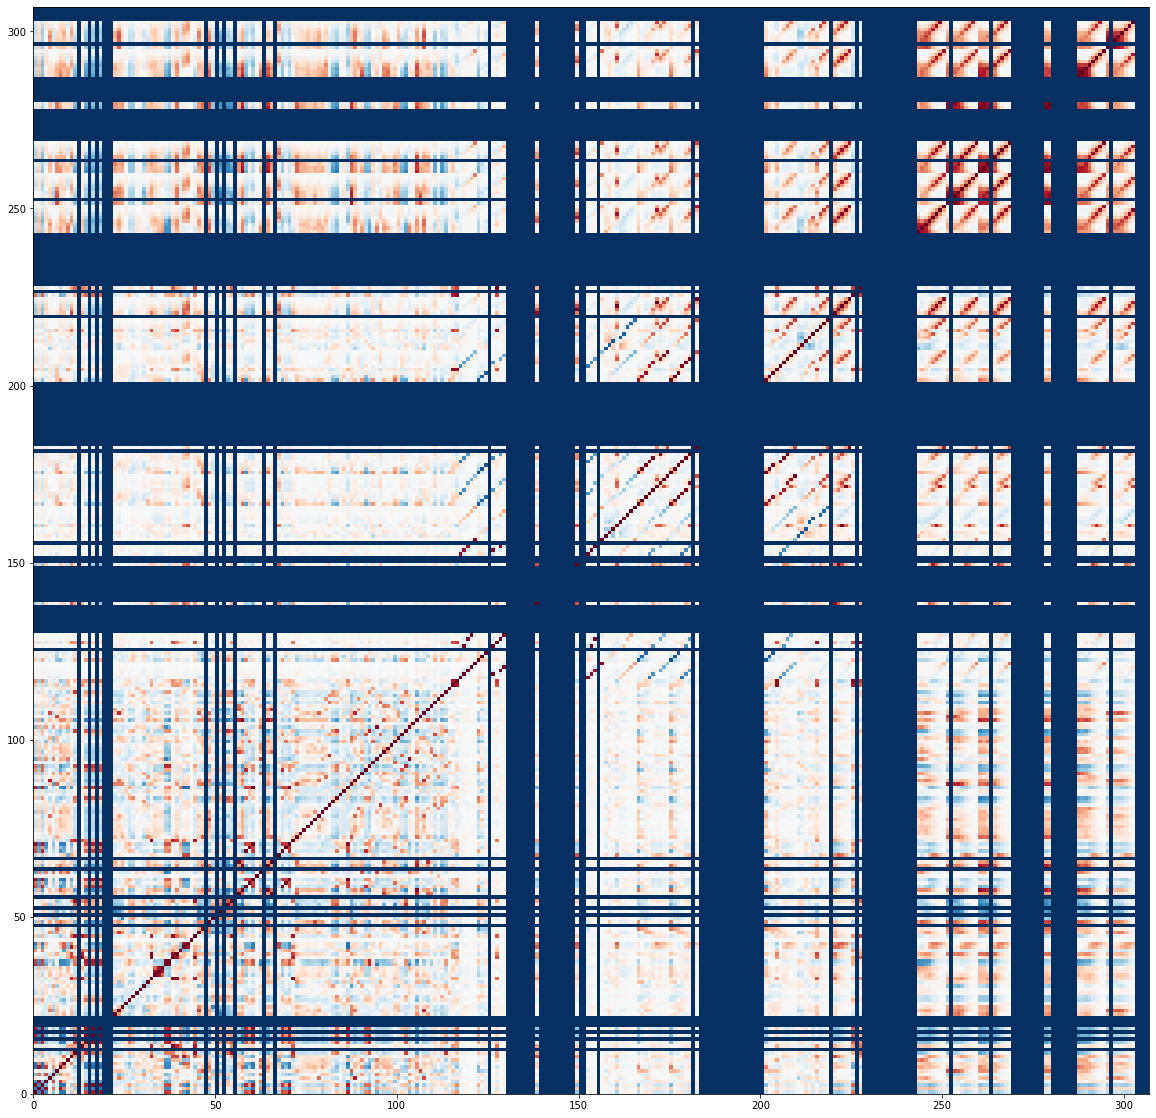

In [48]:
plt.figure(figsize=(20,20))
corr = corrs_all.copy()
corr[~bmask_qm9_all] = -1
corr[:, ~bmask_qm9_all] = -1
plt.pcolormesh(corr, cmap='RdBu_r', vmin=-1, vmax=1)

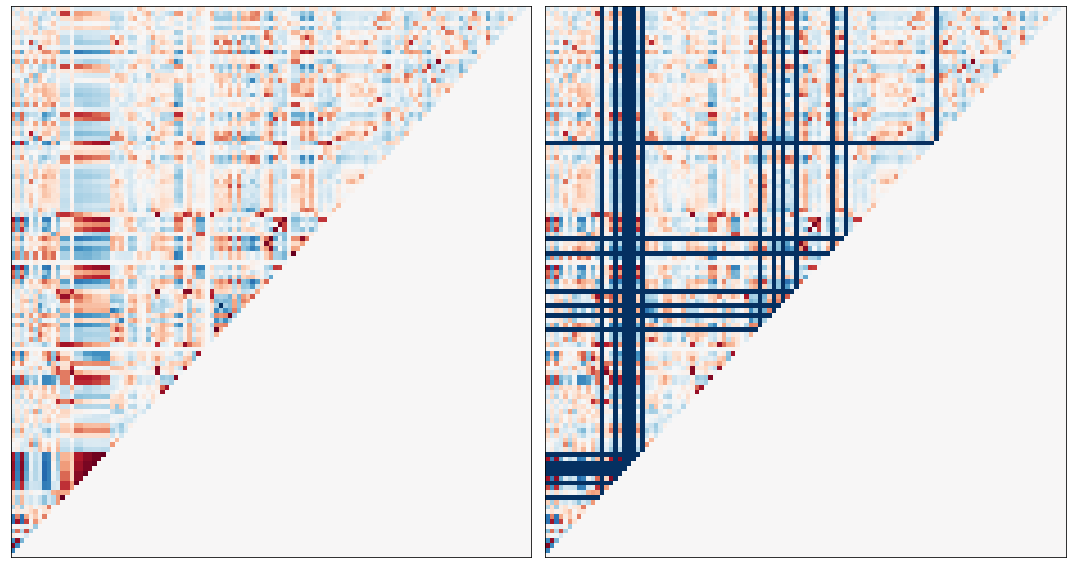

In [114]:
blacklist_high_corr_qm9_desc, bmask_qm9_desc = screen_by_cc(corr_qm9_desc, name_qm9_desc, 0.95, info=False)

f, axs = plt.subplots(1, 2, figsize=(15,8))
corr = corr_qm9_desc.copy()
for i in range(corr.shape[0]): corr[i,i:] = 0
axs[0].pcolormesh(corr, cmap='RdBu_r', vmin=-1, vmax=1)
corr = corr_qm9_desc.copy()
corr[~bmask_qm9_desc] = -1
corr[:, ~bmask_qm9_desc] = -1
for i in range(corr.shape[0]): corr[i,i:] = 0
axs[1].pcolormesh(corr, cmap='RdBu_r', vmin=-1, vmax=1)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

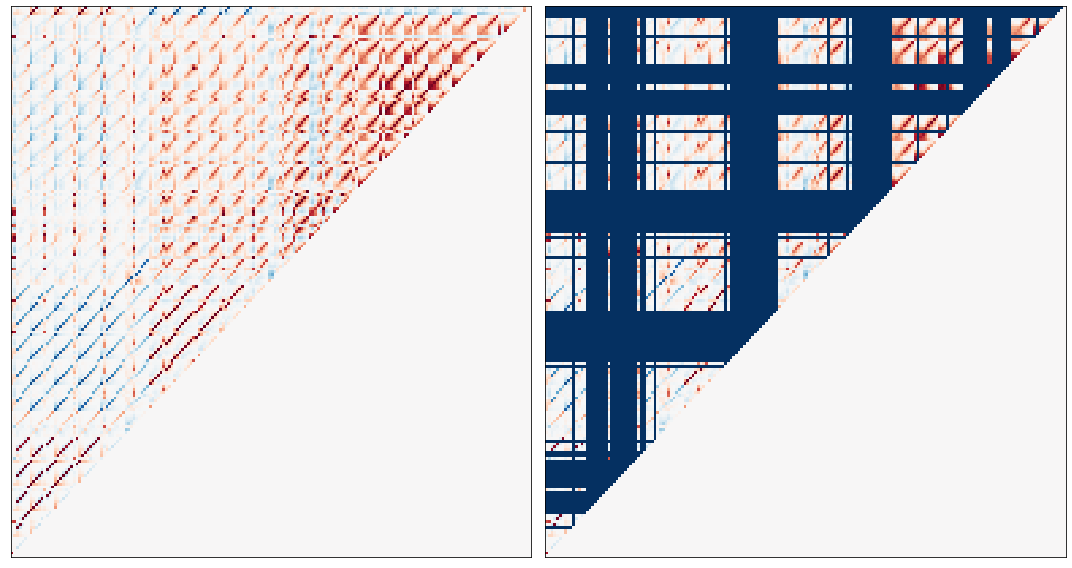

In [115]:
blacklist_high_corr_qm9_acr2, bmask_qm9_acr2 = screen_by_cc(corr_qm9_acr2, name_qm9_acr2, 0.97)

f, axs = plt.subplots(1, 2, figsize=(15,8))
corr = corr_qm9_acr2.copy()
for i in range(corr.shape[0]): corr[i,i:] = 0
axs[0].pcolormesh(corr, cmap='RdBu_r', vmin=-1, vmax=1)
corr[~bmask_qm9_acr2] = -1
corr[:, ~bmask_qm9_acr2] = -1
for i in range(corr.shape[0]): corr[i,i:] = 0
axs[1].pcolormesh(corr, cmap='RdBu_r', vmin=-1, vmax=1)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

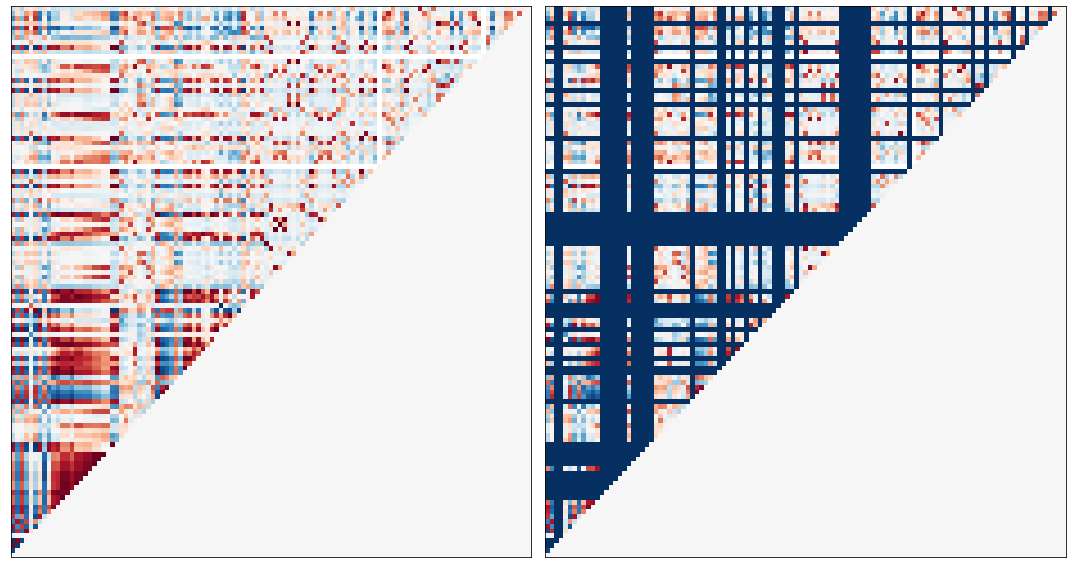

In [116]:
blacklist_high_corr_fpoly_desc, bmask_fpoly_desc = screen_by_cc(corr_fpoly_desc, name_qm9_desc, 0.95, info=False)

f, axs = plt.subplots(1, 2, figsize=(15,8))
corr = corr_fpoly_desc.copy()
for i in range(corr.shape[0]): corr[i,i:] = 0
axs[0].pcolormesh(corr, cmap='RdBu_r', vmin=-1, vmax=1)
corr = corr_fpoly_desc.copy()
corr[~bmask_fpoly_desc] = -1
corr[:, ~bmask_fpoly_desc] = -1
for i in range(corr.shape[0]): corr[i,i:] = 0
axs[1].pcolormesh(corr, cmap='RdBu_r', vmin=-1, vmax=1)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

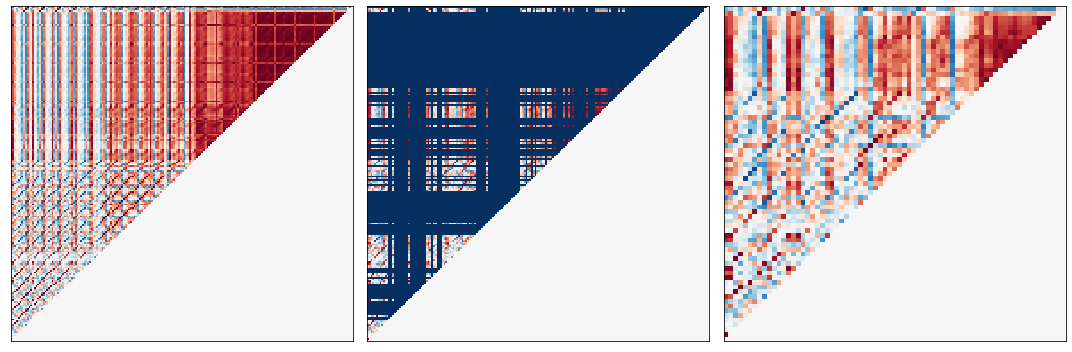

In [17]:
blacklist_high_corr_fpoly_acr2, bmask_fpoly_acr2 = screen_by_cc(corr_fpoly_acr2, name_qm9_acr2, 0.97)

f, axs = plt.subplots(1, 3, figsize=(15,5))
corr = corr_fpoly_acr2.copy()
for i in range(corr.shape[0]): corr[i,i:] = 0
axs[0].pcolormesh(corr, cmap='RdBu_r', vmin=-1, vmax=1)
corr[~bmask_fpoly_acr2] = -1
corr[:, ~bmask_fpoly_acr2] = -1
for i in range(corr.shape[0]): corr[i,i:] = 0
axs[1].pcolormesh(corr, cmap='RdBu_r', vmin=-1, vmax=1)
axs[2].pcolormesh(corr[bmask_fpoly_acr2][:,bmask_fpoly_acr2], cmap='RdBu_r', vmin=-1, vmax=1)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [3]:
m = Chem.MolFromSmiles("O=C(NCc1cc(OC)c(O)cc1)CCCC/C=C/C(C)C")

Descriptors.AUTOCORR2D_1(m)

3.205

In [16]:
import ypack.utils.rdkit as YR
#%load_ext autoreload
#%autoreload 2
rdmol = YR.RDKitMoleculeDescriptor(include_autocorr=True)
rdmol.get(m)


array([[ 6.44292659e+00,  4.47718254e-01,  6.44292659e+00,
         4.47718254e-01,  6.09849775e-01,  4.49800922e-01,
         2.94248000e+02,  3.29271865e+02,  4.49800922e-01,
         0.00000000e+00,  4.49800922e-01, -3.77275037e-01,
         3.77275037e-01,  6.76851880e-02,  1.00000000e+00,
         1.75000000e+00,  2.37500000e+00,  4.49800922e-01,
         4.49800922e-01,  2.51126027e+00, -2.53927087e+00,
         2.53750352e+00, -2.53886164e+00,  5.26480323e+00,
        -1.20206430e-01,  1.72303636e+00,  4.49800922e-01,
         1.67778101e+01,  1.55457120e+01,  1.55457120e+01,
         1.18468666e+01,  1.02196313e+01,  1.02196313e+01,
         7.85534055e+00,  7.85534055e+00,  6.14234463e+00,
         6.14234463e+00,  4.61715868e+00,  4.61715868e+00,
        -8.60000000e-01,  4.49800922e-01,  1.79468421e+01,
         9.00912420e+00,  4.49800922e-01,  1.56800000e-02,
         1.56800000e-02,  1.56800000e-02,  1.56800000e-02,
         1.56800000e-02,  1.56800000e-02,  1.56800000e-0

In [21]:
fncs[0][1](m)

3.205

### 3d Descriptors

In [277]:
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors3D

desc3d_list = [(n,f) for n,f in getmembers(Descriptors3D, isfunction)]

m = Chem.MolFromSmiles("O=C(NCc1cc(OC)c(O)cc1)CCCC/C=C/C(C)C")
m = Chem.AddHs(m)
cids = AllChem.EmbedMultipleConfs(m, numConfs=10)
res = AllChem.MMFFOptimizeMoleculeConfs(m)

- Conformer 생성
  - 3D 데이터를 담고있는 conformer를 만들어야 3D descriptor 계산 가능함
  - 계산 결과, random state에 의해 달라지느 conformer로 인하여 최적화를 하더라도 descriptor 값이 크게 요동치는 것을 확인함


In [308]:
import matplotlib.pyplot as plt
%matplotlib inline

conf = []
opt  = []
for i in range(1000):
    m = Chem.MolFromSmiles("O=C(NCc1cc(OC)c(O)cc1)CCCC/C=C/C(C)C")
    m = Chem.AddHs(m)
    AllChem.EmbedMolecule(m)
    conf.append(Descriptors3D.Asphericity(m))
    AllChem.MMFFOptimizeMolecule(m)
    opt.append(Descriptors3D.Asphericity(m))

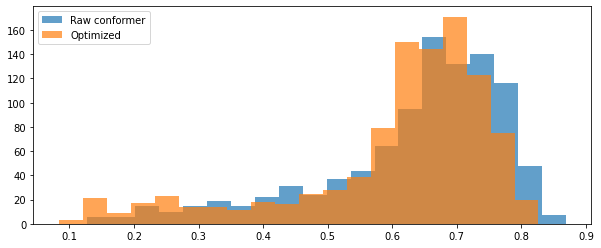

In [307]:
f, ax = plt.subplots(1,1,figsize=(10,4))
ax.hist(conf, bins=20, alpha=0.7, label='Raw conformer')
ax.hist(opt, bins=20, alpha=0.7, label='Optimized')
ax.legend(loc='upper left')

## Structure analysis

In [19]:
from rdkit import Chem
import pickle
m = Chem.MolFromSmiles("O=C(NCc1cc(OC)c(O)cc1)CCCC/C=C/C(C)C")

### atoms

In [20]:
atoms = [a for a in m.GetAtoms()]

In [121]:
atom_fncs = {
    'GetIdx': lambda x: x.GetIdx(),
    'GetAtomicNum': lambda x: x.GetAtomicNum(),
    'GetMass': lambda x: x.GetMass(),
#    'GetBonds': lambda x: [b for b in x.GetBonds()],
#    'GetNeighbors': lambda x: [n.GetIdx() for n in x.GetNeighbors()],
    'GetDegree': lambda x: x.GetDegree(),
    'GetFormalCharge': lambda x: x.GetFormalCharge(),
    'GetImplicitValence': lambda x: x.GetImplicitValence(),
    'GetExplicitValence': lambda x: x.GetExplicitValence(),
    'GetHybridization': lambda x: x.GetHybridization(),
    'GetIsAromatic': lambda x: x.GetIsAromatic(),
    'GetIsotope': lambda x: x.GetIsotope(),
    'GetMonomerInfo': lambda x: x.GetMonomerInfo(),
    'GetNoImplicit': lambda x: x.GetNoImplicit(),
    'GetNumImplicitHs': lambda x: x.GetNumImplicitHs(),
    'GetNumExplicitHs': lambda x: x.GetNumExplicitHs(),
    'GetNumRadicalElectrons': lambda x: x.GetNumRadicalElectrons(),
    'GetPDBResidueInfo': lambda x: x.GetPDBResidueInfo(),
    'GetTotalDegree': lambda x: x.GetTotalDegree(),
    'GetTotalNumHs': lambda x: x.GetTotalNumHs(),
    'GetTotalValence': lambda x: x.GetTotalValence(),
}

In [27]:
atom = atoms[5]
atom.IsInRing(), atom.GetIsAromatic()

(True, True)

- print by data

In [122]:
for name, fnc in atom_fncs.items():
    print('-'*5, name, '-'*20)
    for i, atom in enumerate(atoms):
        print(i, fnc(atom))

----- GetIdx --------------------
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
----- GetAtomicNum --------------------
0 8
1 6
2 7
3 6
4 6
5 6
6 6
7 8
8 6
9 6
10 8
11 6
12 6
13 6
14 6
15 6
16 6
17 6
18 6
19 6
20 6
21 6
----- GetMass --------------------
0 15.999
1 12.011
2 14.007
3 12.011
4 12.011
5 12.011
6 12.011
7 15.999
8 12.011
9 12.011
10 15.999
11 12.011
12 12.011
13 12.011
14 12.011
15 12.011
16 12.011
17 12.011
18 12.011
19 12.011
20 12.011
21 12.011
----- GetDegree --------------------
0 1
1 3
2 2
3 2
4 3
5 2
6 3
7 2
8 1
9 3
10 1
11 2
12 2
13 2
14 2
15 2
16 2
17 2
18 2
19 3
20 1
21 1
----- GetFormalCharge --------------------
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
----- GetImplicitValence --------------------
0 0
1 0
2 1
3 2
4 0
5 1
6 0
7 0
8 3
9 0
10 1
11 1
12 1
13 2
14 2
15 2
16 2
17 1
18 1
19 1
20 3
21 3
----- GetExplicitValence ------------------

- print by atom

In [123]:
for atom in atoms:
    print('-'*80)
    for name, fnc in atom_fncs.items():
        print(f'{name:25}', fnc(atom))

--------------------------------------------------------------------------------
GetIdx                    0
GetAtomicNum              8
GetMass                   15.999
GetDegree                 1
GetFormalCharge           0
GetImplicitValence        0
GetExplicitValence        2
GetHybridization          SP2
GetIsAromatic             False
GetIsotope                0
GetMonomerInfo            None
GetNoImplicit             False
GetNumImplicitHs          0
GetNumExplicitHs          0
GetNumRadicalElectrons    0
GetPDBResidueInfo         None
GetTotalDegree            1
GetTotalNumHs             0
GetTotalValence           2
--------------------------------------------------------------------------------
GetIdx                    1
GetAtomicNum              6
GetMass                   12.011
GetDegree                 3
GetFormalCharge           0
GetImplicitValence        0
GetExplicitValence        4
GetHybridization          SP2
GetIsAromatic             False
GetIsotope            

### bonds

In [28]:
bonds = [a for a in m.GetBonds()]

bond_fncs = {
    'GetIdx': lambda x: x.GetIdx(),
    'GetBeginAtomIdx': lambda x: x.GetBeginAtomIdx(),
    'GetEndAtomIdx': lambda x: x.GetEndAtomIdx(),
    'GetBondDir': lambda x: x.GetBondDir(),
    'GetBondType': lambda x: x.GetBondType(),
    'GetBondTypeAsDouble': lambda x: x.GetBondTypeAsDouble(),
    'GetIsAromatic': lambda x: x.GetIsAromatic(),
    'GetIsConjugated': lambda x: x.GetIsConjugated(),
}

In [37]:
Descriptors.descList

[('MaxEStateIndex',
  <function rdkit.Chem.EState.EState.MaxEStateIndex(mol, force=1)>),
 ('MinEStateIndex',
  <function rdkit.Chem.EState.EState.MinEStateIndex(mol, force=1)>),
 ('MaxAbsEStateIndex',
  <function rdkit.Chem.EState.EState.MaxAbsEStateIndex(mol, force=1)>),
 ('MinAbsEStateIndex',
  <function rdkit.Chem.EState.EState.MinAbsEStateIndex(mol, force=1)>),
 ('qed',
  <function rdkit.Chem.QED.qed(mol, w=QEDproperties(MW=0.66, ALOGP=0.46, HBA=0.05, HBD=0.61, PSA=0.06, ROTB=0.65, AROM=0.48, ALERTS=0.95), qedProperties=None)>),
 ('MolWt', <function rdkit.Chem.Descriptors.<lambda>(*x, **y)>),
 ('HeavyAtomMolWt', <function rdkit.Chem.Descriptors.HeavyAtomMolWt(x)>),
 ('ExactMolWt', <function rdkit.Chem.Descriptors.<lambda>(*x, **y)>),
 ('NumValenceElectrons',
  <function rdkit.Chem.Descriptors.NumValenceElectrons(mol)>),
 ('NumRadicalElectrons',
  <function rdkit.Chem.Descriptors.NumRadicalElectrons(mol)>),
 ('MaxPartialCharge',
  <function rdkit.Chem.Descriptors.MaxPartialCharge(mo

- print by data

In [125]:
for name, fnc in bond_fncs.items():
    print('-'*5, name, '-'*10)
    for i, bond in enumerate(bonds):
        print(i, fnc(bond))

----- GetIdx ----------
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
----- GetBeginAtomIdx ----------
0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 6
9 9
10 9
11 11
12 1
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 19
21 12
----- GetEndAtomIdx ----------
0 1
1 2
2 3
3 4
4 5
5 6
6 7
7 8
8 9
9 10
10 11
11 12
12 13
13 14
14 15
15 16
16 17
17 18
18 19
19 20
20 21
21 4
----- GetBondDir ----------
0 NONE
1 NONE
2 NONE
3 NONE
4 NONE
5 NONE
6 NONE
7 NONE
8 NONE
9 NONE
10 NONE
11 NONE
12 NONE
13 NONE
14 NONE
15 NONE
16 ENDUPRIGHT
17 NONE
18 ENDUPRIGHT
19 NONE
20 NONE
21 NONE
----- GetBondType ----------
0 DOUBLE
1 SINGLE
2 SINGLE
3 SINGLE
4 AROMATIC
5 AROMATIC
6 SINGLE
7 SINGLE
8 AROMATIC
9 SINGLE
10 AROMATIC
11 AROMATIC
12 SINGLE
13 SINGLE
14 SINGLE
15 SINGLE
16 SINGLE
17 DOUBLE
18 SINGLE
19 SINGLE
20 SINGLE
21 AROMATIC
----- GetBondTypeAsDouble ----------
0 2.0
1 1.0
2 1.0
3 1.0
4 1.5
5 1.5
6 1.0
7 1.0
8 1.5
9 1.0
10 1.5
11 1.5
12 1.0
13 

- print by atom

In [126]:
for bond in bonds:
    print('-'*80)
    for name, fnc in bond_fncs.items():
        print(f'{name:25}', fnc(bond))

--------------------------------------------------------------------------------
GetIdx                    0
GetBeginAtomIdx           0
GetEndAtomIdx             1
GetBondDir                NONE
GetBondType               DOUBLE
GetBondTypeAsDouble       2.0
GetIsAromatic             False
GetIsConjugated           True
--------------------------------------------------------------------------------
GetIdx                    1
GetBeginAtomIdx           1
GetEndAtomIdx             2
GetBondDir                NONE
GetBondType               SINGLE
GetBondTypeAsDouble       1.0
GetIsAromatic             False
GetIsConjugated           True
--------------------------------------------------------------------------------
GetIdx                    2
GetBeginAtomIdx           2
GetEndAtomIdx             3
GetBondDir                NONE
GetBondType               SINGLE
GetBondTypeAsDouble       1.0
GetIsAromatic             False
GetIsConjugated           False
---------------------------------

### QM9 data distribution

In [147]:
import os
df = pd.read_csv('D:/DATA/polymers/QM9/qm9_origin.csv')

# generate and save as chunk
data = []
for i, smiles in tqdm(enumerate(df.smiles), total=df.shape[0]):
    m = Chem.MolFromSmiles(smiles)
    atoms = m.GetAtoms()
    bonds = m.GetBonds()
    atom_prop = {}
    bond_prop = {}
    for name, fnc in atom_fncs.items():
        atom_prop[name] = [fnc(atom) for atom in atoms]
    for name, fnc in bond_fncs.items():
        bond_prop[name] = [fnc(bond) for bond in bonds]
    data.append([atom_prop, bond_prop])
    if len(data) == 10000:
        with open(f'D:/DATA/polymers/QM9/temp/{i+1}.pickle','wb') as f:
            pickle.dump(data, f)
        data = []
with open(f'D:/DATA/polymers/QM9/temp/{i+1}.pickle','wb') as f:
    pickle.dump(data, f)

100%|██████████| 14/14 [00:00<00:00, 46.03it/s]


In [ ]:
# re-load chunk and merge
data = []
for i in range(200000):
    fn = f'D:/DATA/polymers/QM9/temp/{i}.pickle'
    if not os.path.isfile(fn): continue
    aps = {}
    bps = {}
    with open(fn, 'rb') as f:
        d = pickle.load(f)
    for ap, bp in tqdm(d, desc=f'{i}.pickle'):
        for k, v in ap.items():
            if k not in aps: 
                aps[k] = np.array(v)
            else:
                aps[k] = np.hstack([aps[k], v])
        for k, v in bp.items():
            if k not in bps: 
                bps[k] = np.array(v)
            else:
                bps[k] = np.hstack([bps[k], v])
    data.append([aps, bps])

# final merge
atom_props = {}
bond_props = {}

for ap, bp in tqdm(data):
    for k, v in ap.items():
        if k not in atom_props: 
            atom_props[k] = np.array(v)
        else:
            atom_props[k] = np.hstack([atom_props[k], v])
    for k, v in bp.items():
        if k not in bond_props: 
            bond_props[k] = np.array(v)
        else:
            bond_props[k] = np.hstack([bond_props[k], v])

In [154]:
for k,v in atom_props.items():
    if v[0] is None:
        print(f'{k:25s}  : {np.sum(v == None):10d} / {v.shape[0]:10d}')
    else:
        print(f'{k:25s}  : {np.var(v):10.3f} / {np.min(v):10.3f} / {np.max(v):10.3f}',)

GetIdx                     :      6.477 /      0.000 /      8.000
GetAtomicNum               :      0.583 /      6.000 /      9.000
GetMass                    :      2.351 /     12.011 /     18.998
GetDegree                  :      0.707 /      0.000 /      4.000
GetFormalCharge            :      0.003 /     -1.000 /      1.000
GetImplicitValence         :      0.965 /      0.000 /      4.000
GetExplicitValence         :      0.911 /      0.000 /      4.000
GetHybridization           :      0.372 /      2.000 /      4.000
GetIsAromatic              :      0.098 /      0.000 /      1.000
GetIsotope                 :      0.000 /      0.000 /      0.000
GetMonomerInfo             :    1177631 /    1177631
GetNoImplicit              :      0.003 /      0.000 /      1.000
GetNumImplicitHs           :      0.965 /      0.000 /      4.000
GetNumExplicitHs           :      0.015 /      0.000 /      3.000
GetNumRadicalElectrons     :      0.000 /      0.000 /      0.000
GetPDBResidueInfo      

In [169]:
atom_props.pop('GetMonomerInfo')
atom_props.pop('GetPDBResidueInfo')
atom_props.pop('GetIsotope')
atom_props.pop('GetNumRadicalElectrons')

array([0, 0, 0, ..., 0, 0, 0])

In [155]:
for k,v in bond_props.items():
    if v[0] is None:
        print(f'{k:25s}  : {np.sum(v == None):10d} / {v.shape[0]:10d}')
    else:
        print(f'{k:25s}  : {np.var(v):10.3f} / {np.min(v):10.3f} / {np.max(v):10.3f}',)

GetIdx                     :      7.947 /      0.000 /     12.000
GetBeginAtomIdx            :      5.871 /      0.000 /      8.000
GetEndAtomIdx              :      5.296 /      0.000 /      8.000
GetBondDir                 :      0.000 /      0.000 /      0.000
GetBondType                :     11.167 /      1.000 /     12.000
GetBondTypeAsDouble        :      0.184 /      1.000 /      3.000
GetIsAromatic              :      0.093 /      0.000 /      1.000
GetIsConjugated            :      0.171 /      0.000 /      1.000


In [170]:
bond_props.pop('GetBondDir')

array([0., 0., 0., ..., 0., 0., 0.])

In [227]:
from ypack.utils.ptable import load_atom_feat_matrix
ptable = load_atom_feat_matrix(norm=True)

apmat = np.array([v for v in atom_props.values()])
bpmat = np.array([v for v in bond_props.values()])
ptmat = ptable[apmat[1].astype(int) - 1].T

apmat.shape, bpmat.shape, ptmat.shape

((15, 1177631), (7, 1258966), (15, 1177631))

c:\Users\Yang\anaconda3\envs\poly\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\Users\Yang\anaconda3\envs\poly\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


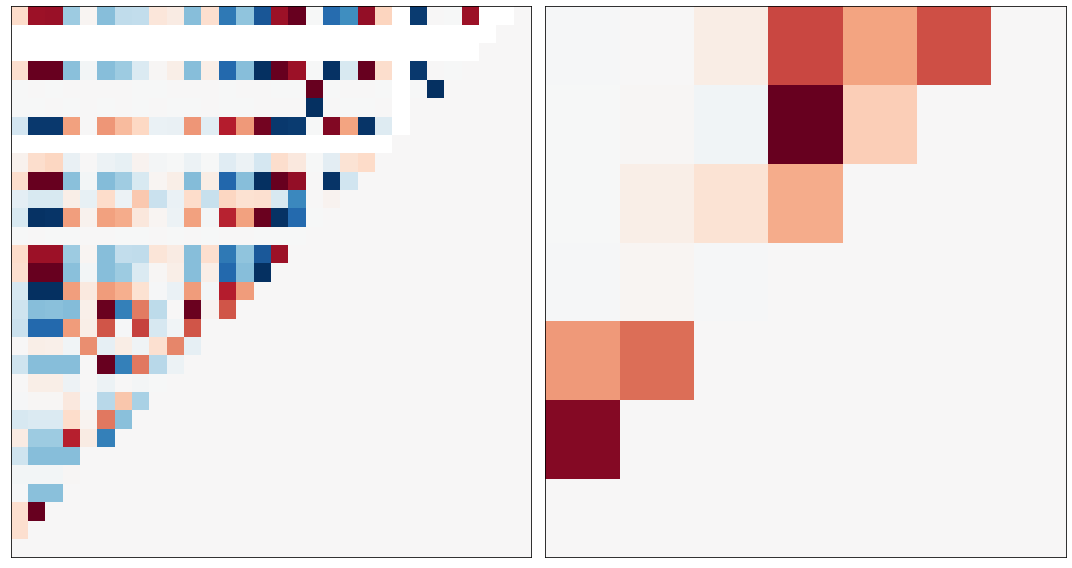

In [228]:
f, axs = plt.subplots(1, 2, figsize=(15,8))
corr = np.corrcoef(np.vstack([apmat, ptmat]))
for i in range(corr.shape[0]): corr[i,i:] = 0
axs[0].pcolormesh(corr, cmap='RdBu_r', vmin=-1, vmax=1)

corr = np.corrcoef(bpmat)
for i in range(corr.shape[0]): corr[i,i:] = 0
axs[1].pcolormesh(corr, cmap='RdBu_r', vmin=-1, vmax=1)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()